# Importando Libs

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
from collections import Counter
import spacy

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
import tensorflow as tf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Funções

## mean_absolute_percentage_error

In [19]:
def mean_absolute_percentage_error(y_true, y_pred,*args): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

# Treino e Teste run_exps_train_test

## init_parameter_model

In [45]:
def init_parameter_model():
  #models = []
  models =  [           
          ('LR', LogisticRegression()),
          ('LDA', LinearDiscriminantAnalysis()),
          ('DT', DecisionTreeClassifier()),
          #('RF', RandomForestClassifier()),
          #('KNN', KNeighborsClassifier()),
          #('SVM', SVC()),
          ('MNB', MultinomialNB()),
          ('ABO', AdaBoostClassifier()),
          ('GNB', GaussianNB()),
          #('GBO', GradientBoostingClassifier()),
          ('EXT', ExtraTreesClassifier()),
          #('XGB', XGBClassifier()),
          ('MLP', MLPClassifier())      
        ]

  """knn_grid = {'n_neighbors': [3,5, 7], 'weights': ["uniform", "distance"], 'p' : [1,2,3]}
     
  for n_neighbors_value in knn_grid['n_neighbors']:
    for weights_value in knn_grid['weights']:
      for p_value in knn_grid['p']:
        knn_params = ['KNN',n_neighbors_value,weights_value, p_value]
        model = (f"KNN_{n_neighbors_value}_{weights_value}_{p_value}" , KNeighborsRegressor(n_neighbors=n_neighbors_value,weights = weights_value, p=p_value  ), knn_params)
        models.append(model)"""
 
  """mlp_grid = {'alpha' : [0.01, 0.0003,0.0005], 'learning_rate_init': [0.001, 0.003,0.005], 'power_t' : [0.5,0.7,0.9]}
  mlp_parms = []
  for alpha_value in mlp_grid['alpha']:
      for learning_rate_init_value in mlp_grid['learning_rate_init']:
        for power_t_value in mlp_grid['power_t']:
          mlp_params = ['MLP', alpha_value,learning_rate_init_value, power_t_value]
          model = (f"MLP_{alpha_value}_{learning_rate_init_value}_{power_t_value}" , MLPRegressor(alpha=alpha_value,learning_rate_init = learning_rate_init_value, power_t=power_t_value), mlp_params)
          models.append(model)"""

  return models      

## run_exps_train_test

In [126]:
from sklearn.metrics import precision_recall_fscore_support


def run_exps_train_test(x_train: pd.DataFrame ,
             y_train: pd.DataFrame,
             x_test: pd.DataFrame,
             y_test: pd.DataFrame, models_params=None) -> pd.DataFrame:

    models = [
          #('KNN', KNeighborsRegressor(n_neighbors=params[1],weights =params[2], p=params[3]  )),
          #('MLP', MLPRegression),
        ]
    
    models = init_parameter_model()
    dfs = []
    #Modelos que serão avaliados (podem incluir quantos modelos quiserem)
    """for params in models_params:
      if 'KNN' == params['p0']:
        models.append(('KNN', KNeighborsRegressor(n_neighbors=int(params['p1']),weights =params['p2'], p=int(params['p3'])  ))),
      elif 'MLP' == params['p0']:
        models.append(('MLP', MLPRegressor(alpha=params['p1'],learning_rate_init=params['p2'], power_t=params['p3']  ))),"""

    dfs = []
    results = []
    names = []
    #Métricas que serão avaliadas (podem incluir quantos métricas quiserem)
    mse  =  make_scorer(mean_squared_error)
    mape =  make_scorer(mean_absolute_percentage_error)
    kappa_scorer = make_scorer(cohen_kappa_score)
    scoring = { 
                'accuracy': 'accuracy',
                'precision_weighted': 'precision_weighted',
                'recall_weighted': 'recall_weighted',
                'f1_weighted': 'f1_weighted',
                'kappa' : kappa_scorer,
                'mse': mse,
                'mape': mape
                }
                
    for name, model in models:

        clf = model.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
       
        #print(classification_report(y_test, y_pred))

        this_df = pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).transpose()
        
        """this_df = pd.DataFrame(list(precision_recall_fscore_support(y_test, y_pred,average='weighted')),
            index=['Precision', 'Recall', 'F1-score', 'Support']).T"""
        
        
        #this_df = this_df.groupby(['model']).mean()
        this_df['model'] = name
        dfs.append(this_df)       
    final = pd.concat(dfs, ignore_index=True)
    return final

        

## run_exps_crossvalidation

In [22]:

def run_exps_crossvalidation(x: pd.DataFrame ,
             y: pd.DataFrame) -> pd.DataFrame:
    """
    Lightweight script to test many models and find winners
    :param x: values vector
    :param y: target vector
    :return: DataFrame of predictions
    """

    dfs = []
    print("CARREGANDO MODELO")
    # Init hte models
    models = init_parameter_model()
    results = []
    names = []
    kappa_scorer = make_scorer(cohen_kappa_score)
    mse  =  make_scorer(mean_squared_error)
    mape =  make_scorer(mean_absolute_percentage_error)
    scoring = { 
                'accuracy': 'accuracy',
                'precision_weighted': 'precision_weighted',
                'recall_weighted': 'recall_weighted',
                'f1_weighted': 'f1_weighted',
                'kappa' : kappa_scorer,
                'mse': mse,
                'mape': mape
                }
    print("RODANDO")
    #for name, model, params in models:
    for name, model in models:
        print(name)

        kfold = model_selection.KFold(n_splits=10, shuffle=False)

        cv_results = model_selection.cross_validate(model, x, y, cv=kfold, scoring=scoring,)
        
        #print(cv_results)

        results.append(cv_results)

        names.append(name)
        this_df = pd.DataFrame(cv_results)
        
        this_df['model'] = name
        """this_df['p0'] = params[0]
        this_df['p1'] = params[1]
        this_df['p2'] = params[2]
        this_df['p3'] = params[3]"""
        dfs.append(this_df)

    final = pd.concat(dfs, ignore_index=True)
    return final


# Carregar o Conjunto de Dados

In [67]:
df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/cryptcoin/vader_compound_score_en_cleantext_tweet.csv')
#norm_gas_prices_brazil_df = norm_gas_prices_brazil_df.drop(['Unnamed: 0'], axis=1)
df = df.dropna(subset=['cleantext'])


In [73]:
df = df.dropna(subset=['target'])

df[ (df['target'] != 'positive') & (df['target'] != 'negative')  & (df['target'] != 'neutral')].head()

,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,language,compound_vader_score,target,cleantext


In [103]:
Y = df['target'].astype('category').cat.codes
#X = df[['cleantext', 'compound_vader_score']]
Y.value_counts()

2    925177
0    235272
1     15761
dtype: int64

In [25]:
df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/cryptcoin/tweet_select_features.csv')
X = df

In [26]:
Y.shape


(1177791,)

In [27]:
X.shape

(1177791, 50)

# Divisao Treino e Teste

In [28]:
#X_train, X_test, y_train, y_test = train_test_split(new_X_tf_train, Y_tfidf, test_size=0.15)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

In [30]:
X_train.shape

(1001122, 50)

In [31]:
X_test.shape

(176669, 50)

In [32]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [33]:
X_val.shape

(88334, 50)

In [21]:
X_test.shape

(88335, 50)

# Validação Cruzada

In [22]:
%%time
val_final = run_exps_crossvalidation(X_train, y_train)

CARREGANDO MODELO
RODANDO
LR
LDA
DT
MNB
ABO
GNB
EXT
MLP
CPU times: user 1h 19s, sys: 24min 18s, total: 1h 24min 38s
Wall time: 55min 31s


In [23]:
val_final[['model','test_accuracy',	'test_precision_weighted',	'test_recall_weighted',	'test_f1_weighted',	'test_kappa']].tail()

,model,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_kappa
75,MLP,0.783602,0.614033,0.783602,0.688531,0.0
76,MLP,0.785101,0.616383,0.785101,0.690586,0.0
77,MLP,0.787848,0.620704,0.787848,0.694359,0.0
78,MLP,0.787128,0.619571,0.787128,0.693371,0.0
79,MLP,0.784232,0.615019,0.784232,0.689394,0.0


### Exportar os Resultados Cross-Validation

In [24]:
val_final.to_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/gas_price_brazil/result/vader_score_compound_crossvalidation_classification.csv", index=False) 

## Checando Resultados Validacao

In [5]:
df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/gas_price_brazil/result/vader_score_compound_crossvalidation_classification.csv')
#norm_gas_prices_brazil_df = norm_gas_prices_brazil_df.drop(['Unnamed: 0'], axis=1)


In [15]:
df[df['model'] == 'MLP'][['model','test_accuracy',	'test_precision_weighted',	'test_recall_weighted',	'test_f1_weighted',	'test_kappa']].head()

,model,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_kappa
70,MLP,0.786401,0.618427,0.786401,0.692372,0.0
71,MLP,0.786501,0.618584,0.786501,0.692509,0.0
72,MLP,0.785650,0.617246,0.785650,0.691340,0.0
73,MLP,0.786249,0.618188,0.786249,0.692163,0.0
74,MLP,0.784921,0.616101,0.784921,0.690340,0.0


# Test

In [127]:
%%time
test_result = run_exps_train_test(X_train, y_train, X_test, y_test)

CPU times: user 7min 10s, sys: 2min 57s, total: 10min 8s
Wall time: 6min 46s


In [128]:
test_result

,precision,recall,f1-score,support,model
0,0.000000,0.000000,0.000000,124.000000,LR
1,0.000000,0.000000,0.000000,17828.000000,LR
2,0.000000,0.000000,0.000000,1177.000000,LR
3,0.783449,1.000000,0.878578,69206.000000,LR
4,0.783449,0.783449,0.783449,0.783449,LR
5,0.195862,0.250000,0.219644,88335.000000,LR
6,0.613793,0.783449,0.688321,88335.000000,LR
7,0.000000,0.000000,0.000000,124.000000,LDA
8,0.000000,0.000000,0.000000,17828.000000,LDA
9,0.000000,0.000000,0.000000,1177.000000,LDA


In [99]:
#test_result['model'] = ['LR', 'LDA', 'DT','MNB','ABO','GNB', 'EXT', 'MLP']

In [132]:
test_result.to_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/gas_price_brazil/result/test_tweet_vader_sentiment_analysis_result_classification.csv") 

# Plotar Comparação Algortimos sobre Métricas

In [ ]:
results_long = pd.melt(test_result[['precision','recall','f1-score','model']],id_vars=['model'],var_name='metrics', value_name='values')

In [ ]:
results_long

,model,metrics,values
0,LR,precision,0.000000
1,LR,precision,0.000000
2,LR,precision,0.000000
3,LR,precision,0.783449
4,LR,precision,0.783449
...,...,...,...
163,MLP,f1-score,0.000000
164,MLP,f1-score,0.878578
165,MLP,f1-score,0.783449
166,MLP,f1-score,0.219644


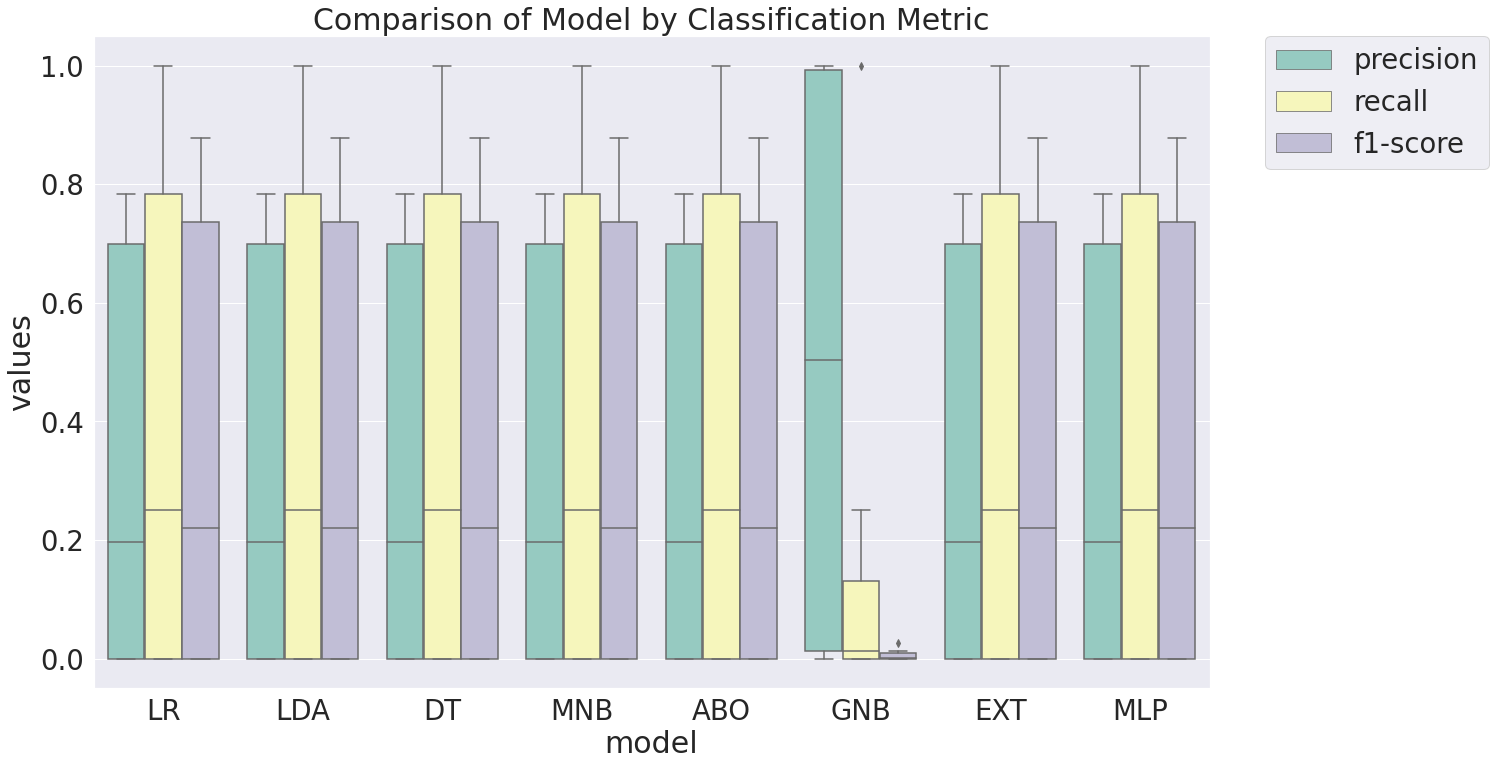

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

## Precision

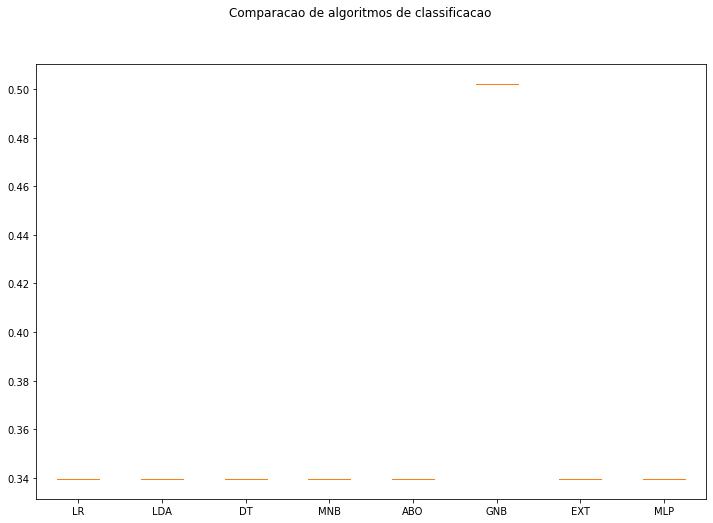

In [107]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Comparacao de algoritmos de classificacao')
ax = fig.add_subplot(111)
plt.boxplot(test_result[['precision']], patch_artist=True)

ax.set_xticklabels(test_result['model'])
plt.show()


## F1-score

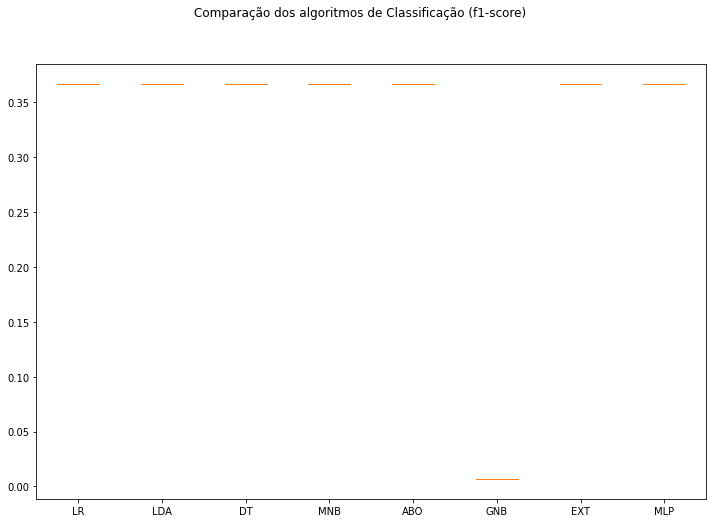

In [110]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Comparação dos algoritmos de Classificação (f1-score)')
ax = fig.add_subplot(111)
plt.boxplot(test_result[['f1-score']], patch_artist=True)

ax.set_xticklabels(test_result['model'])
plt.show()


## Recall

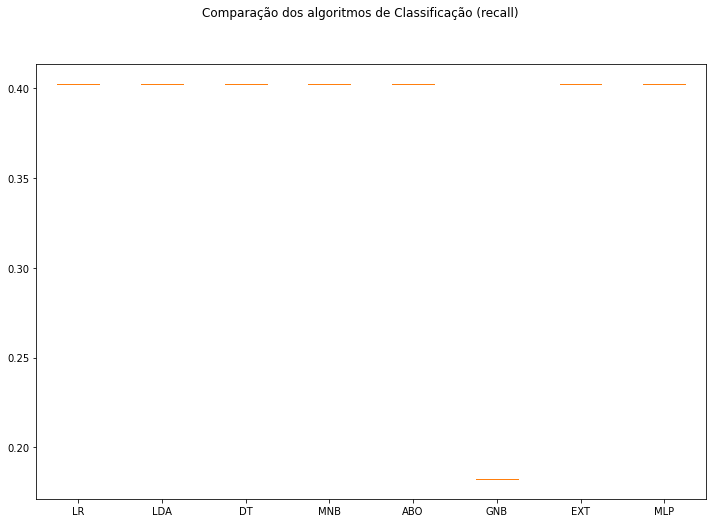

In [111]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Comparação dos algoritmos de Classificação (recall)')
ax = fig.add_subplot(111)
plt.boxplot(test_result[['recall']], patch_artist=True)

ax.set_xticklabels(test_result['model'])
plt.show()


## Support

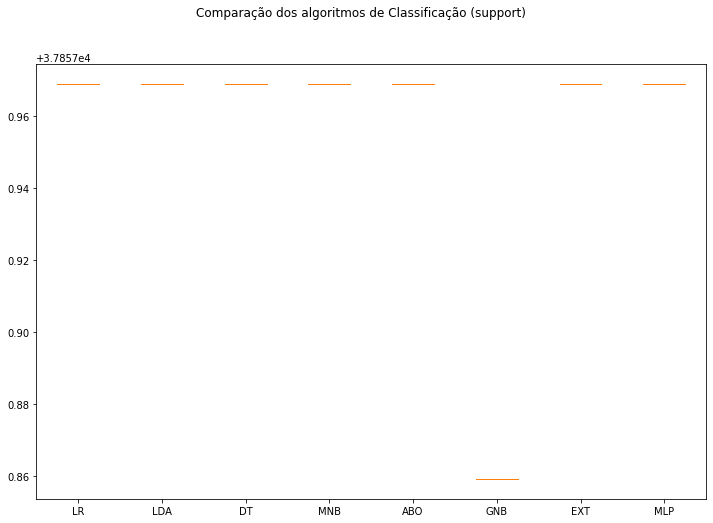

In [112]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Comparação dos algoritmos de Classificação (support)')
ax = fig.add_subplot(111)
plt.boxplot(test_result[['support']], patch_artist=True)

ax.set_xticklabels(test_result['model'])
plt.show()


# Verifica Resultado  Validação Cruzada por Meio do GridSearch

## KNN

### Orderne por MSE

In [ ]:
final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='KNN'].sort_values(['test_mape','test_mse'], ascending=[True,True]).head()

### Melhor configuracao MSE

In [ ]:
knn_mse_best = final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='KNN'].sort_values(['test_mse'], ascending=[True]).head(1)


### Orderne por MAPE

In [ ]:
final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='KNN'].sort_values('test_mape', ascending=True).head()

### Melhor configuracao MAPE

In [ ]:
knn_mape_best = final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='KNN'].sort_values('test_mape', ascending=True).head(1)

### Boxplot

In [ ]:
final[['test_mse','test_mape']][final['p0']=='KNN'].boxplot()

### Histograma

In [ ]:
final['test_mse'][final['p0'] == 'KNN'].hist()

In [ ]:
final['test_mape'][final['p0'] == 'KNN'].hist()

## MLP

### Orderne por MSE

In [ ]:
final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='MLP'].sort_values(['test_mse','test_mape'], ascending=[True,True]).head()

### Melhor configuracao MSE

In [ ]:
mlp_mse_best = final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='MLP'].sort_values(['test_mse','test_mape'], ascending=[True,True]).head(1)

In [ ]:
final[['test_mse','test_mape']].groupby(final['p0']).boxplot()

### Orderne por MAPE

In [ ]:
final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='MLP'].sort_values(['test_mape','test_mse'], ascending=[True,True])

### Melhor configuracao MSE

In [ ]:
mlp_mape_best = final[['p0','p1','p2','p3', 'test_mse','test_mape']][final['p0'] =='MLP'].sort_values(['test_mape','test_mse'], ascending=[True,True]).head(1)

### Boxplot

In [ ]:
final[['test_mse','test_mape']][final['p0']=='MLP'].boxplot()

### Histograma

In [ ]:
final['test_mse'][final['p0'] == 'MLP'].hist()

In [ ]:
final['test_mape'][final['p0'] == 'MLP'].hist()

# Comparativo Agrupado

In [ ]:
grouped = final[['test_mse','test_mape']].groupby(final['p0'])
grouped.mean()

In [ ]:
grouped.std()

# Test

## KNN

In [ ]:
knn_params = knn_mse_best.to_dict('records')
knn_params

In [ ]:
knn_test_result = run_exps_train_test(X_train, y_train, X_test, y_test, knn_params)
knn_test_result

In [ ]:
knn_test_params = [{'p0': 'KNN-GridSearch',
  'p1': 3.0,
  'p2': 'distance',
  'p3': 1.0, 'test_mse': 7.829000609366226e-06}  ] 

pd.DataFrame.from_dict(knn_test_params, orient='columns').head()

In [ ]:
knn_test_result = [{'p0': 'KNN-GridSearch', 'p1': knn_params[0]['p1'] , 'p2': knn_params[0]['p2'], 'p3': knn_params[0]['p3'], 'test_mse': knn_test_result['mse'], 'test_mape': knn_test_result['mape'] }] 


In [ ]:
knn_grid_search = pd.DataFrame.from_dict(knn_test_result, orient='columns').head()
knn_grid_search

## MLP

In [ ]:
mlp_best_parameter = mlp_mse_best.to_dict('records')

In [ ]:
mlp_mse_best

In [ ]:
mlp_params = [{'p0': 'MLP',
  'p1': 0.0003,
  'p2': 0.003,
  'p3': 0.9,
  'test_mape': 0.07546074457540805,
  'test_mse': 3.0343037767688823e-06}]



In [ ]:
pd.DataFrame.from_dict(mlp_mse_best, orient='columns').head()

In [ ]:
mlp_test_result = run_exps_train_test(X_train, y_train, X_test, y_test, mlp_params)

In [ ]:
mlp_test_result = [{'p0': 'MLP-GridSearch', 'p1': mlp_best_parameter[0]['p1'] , 'p2': mlp_best_parameter[0]['p2'], 'p3': mlp_best_parameter[0]['p3'], 'test_mse': mlp_test_result['mse'], 'test_mape': mlp_test_result['mape'] }] 
mlp_test_result

In [ ]:
mlp_grid_search = pd.DataFrame.from_dict(mlp_test_result, orient='columns').head()

In [ ]:
knn_pso = pd.DataFrame.from_dict([{'p0': 'KNN-PSO', 'p1': 3 , 'p2': 1, 'p3': 2, 'test_mse': 7.8710461932141e-06, }]) 

mlp_pso = pd.DataFrame.from_dict([{'p0': 'MLP-PSO', 'p1':0.000637  , 'p2': 0.008086 , 'p3': 0.7794493, 'test_mse':8.520737867942636e-06,  }])


In [ ]:
mlp_grid_search

In [ ]:
mlp_grid_search

In [ ]:
knn_grid_search

In [ ]:
result = pd.concat([knn_grid_search,knn_pso, mlp_grid_search, mlp_pso ])

In [ ]:
result[3:4]

In [ ]:
#https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="p0", y="test_mse", hue="test_mse", data=result, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')